## **Amazon OnePlus Review Dataset**
The data associated with this notebook can be downloaded [here](https://drive.google.com/file/d/1fWJfdJp1KRgdc76qwOE1RuGEKpQqp-3Y/view?usp=sharing)



#**Table of Contents**
* Executive Summary (BLUF)
* Metrics
* Libraries
* Data
* Data Preprocessing
* Feature Importance
* Regressor Development
* Gridsearch XGBRegressor
* Sample Actual vs Predicted Graph
* Learning Curves (Cross Validation)
* Over Predictions (Predictions > Actuals)
* Conclusion


#**Executive Summary (BLUF)**
A regression approach to predict helpful votes of Amazon reviews identified a Random Forest regressor as the winner of a horse race of regressor models. The XGBoost model produces an average MSE of around 900. Given the relatively low stakes, and the ability to cut over to actual helpful votes, automated use of regressor can proceed, but the modeling should be revisited to see if improvements are possible.

#**Metrics**
MSE will be chosen as the primary metric as larger errors are more detrimental than small errors in the predicted ratings. Mean absolute percentage error and the percentage of overpredictions will be reported as supplementary metrics.

#**Libraries**

In [ ]:
# Basic Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import absolute
from numpy import loadtxt
from datetime import datetime
import scipy.stats as ss
from scipy.stats.mstats import winsorize

In [ ]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
# XGBoost & LightGBM
from xgboost import XGBRegressor
import lightgbm as lgb

In [ ]:
# Wordcloud & nltk
!pip install wordcloud
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#**Data**
Data source: https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews?select=20191226-reviews.csv

The features of the data set after preprocessing are as follows:
- time: an integer-values equivalent of date
- title_length: number of characters i title of review
- body_length: number of characters in body of review
- title_positivity: sentiment/positivity score of title as scored by TextBlob
- title_subjectivity: subjectivity score of title as scored by TextBlob  
- body_positivity:: sentiment/positivity score of body as scored by TextBlob
- body_subjectivity: subjectivity score of body as scored by TextBlob
- rating: consumer rating
- verified_True: 1 if reviewer is verified, 0 otherwise
- helpful votes: the number Amazon customers who found the review helpful [**Target**]

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Read in Amazon One PLus Reviews Dataset
file_ = "drive/My Drive/Colab Notebooks/Big Data ML/New BDML/Data/20191226-reviews.csv"   # adapt this as needed to the file structure on your Google drive
df = pd.read_csv(file_) # read in csv file

Mounted at /content/drive


#**Data Preprocessing**

##*Date & Initial Deletions*

In [ ]:
# Convert date to an integer
for i in range(len(df['date'])):
  #print(df.at[i,'date'])
  date = datetime.strptime(str(df.at[i,'date']), '%B %d, %Y')
  date = datetime.timestamp(date)
  df['time']=int(date)

In [ ]:
# Delete asin, name, date
df = df.drop(['asin','name','date'],axis = 1)
df.columns

Index(['rating', 'verified', 'title', 'body', 'helpfulVotes', 'time'], dtype='object')

##*One-Hot Encoding*

In [ ]:
# One-hot encode verified
df = pd.get_dummies(data=df, columns=['verified'],drop_first=True)
df.columns

Index(['rating', 'title', 'body', 'helpfulVotes', 'time', 'verified_True'], dtype='object')

##*Text Pre-Processing*

We will use some code to pre-process the text (title and text of reviews) and then perform EDA on the result

In [ ]:
# Figure length of review title and body
df['title_length'] = df['title'].str.len()
df['body_length'] = df['body'].str.len()

In [ ]:
# Drop instances without a title or body
df = df[df['title'].notna()]
df = df[df['body'].notna()]

In [ ]:
## Change the review title and body type to string
df['title'] = df['title'].astype(str)
df['body'] = df['body'].astype(str)

## Lowercase all reviews
df['title'] = df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['body'] = df['body'].apply(lambda x: " ".join(x.lower() for x in x.split()))



In [ ]:
## remove punctuation
df['title'] = df['title'].str.replace('.','')
df['body'] = df['body'].str.replace('.','')
df['title'] = df['title'].str.replace(',','')
df['body'] = df['body'].str.replace(',','')
df['title'] = df['title'].str.replace('!','')
df['body'] = df['body'].str.replace('!','')
df['title'] = df['title'].str.replace('?','')
df['body'] = df['body'].str.replace('?','')

<ipython-input-12-a7b95e70850a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['title'] = df['title'].str.replace('.','')
<ipython-input-12-a7b95e70850a>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['body'] = df['body'].str.replace('.','')
<ipython-input-12-a7b95e70850a>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['title'] = df['title'].str.replace('?','')
<ipython-input-12-a7b95e70850a>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, singl

In [ ]:
# remove stopwords
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop = set(stopwords_list.decode().splitlines())
#stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['body'] = df['body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
# Stemming
st = PorterStemmer()
df['title'] = df['title'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['body'] = df['body'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [ ]:
## Define a function which can be applied to calculate the score for the whole dataset
def senti(x):
    return TextBlob(x).sentiment.polarity
def subj(x):
    return TextBlob(x).sentiment.subjectivity
df['title_positivity'] = df['title'].apply(senti)
df['title_subjectivity'] = df['title'].apply(subj)
df['body_positivity'] = df['body'].apply(senti)
df['body_subjectivity'] = df['body'].apply(subj)

In [ ]:
# Drop the original 'title' and 'body' columns
df=df.drop(columns=['title','body'],axis=1)

##*kNN Imputation*

Note: these are more than 40,000 missing values in the helpfulVotes feature. Imputing them is a poor idea since we plan to use this as the target variable. The kNN imputation that follows is therefore intended merely to illustrate how kNN imputation is done.  

In [ ]:
# kNN imputation of NaNs in helpfulVotes feature
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer
# define kNN imputer
imputer = KNNImputer()
# fit
imputer.fit(df)
# transform
df_imputed = pd.DataFrame(imputer.transform(df))

In [ ]:
# Figure number of dups
print('Number of dups: ',df.duplicated().sum())

Number of dups:  11387


In [ ]:
# kNN imputation produces thousands of duplicates.
# Accordingly, simnply delete the 40,000+ instances in df with missing values
df =  df.dropna()

##*Split Predictors and Target*

In [ ]:
X_quant = df.drop(['helpfulVotes','rating','verified_True','time'],axis=1)
X_categorical = df[['rating','verified_True']]
X = pd.concat([df['time'],X_quant,X_categorical],axis=1)
col_names = X.columns
y=df['helpfulVotes']

##*Outliers & Skewness*


In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution

# -*- coding: utf-8 -*-
"""
Created on Sat Feb 23 14:42:46 2019
@author: DATAmadness
"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness

# Further documentation available here:
# https://datamadness.github.io/Skewness_Auto_Transform

def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):

    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')

    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series


    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True

        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))

        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])

            if exp:
               #Apply log transformation
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()

        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])

            if exp:
               #Apply exp transformation
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()

        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew

        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()


    return DF


 ------------------------------------------------------

 'title_length' had 'positive' skewness of 1.46

 Transformation yielded skewness of -0.01


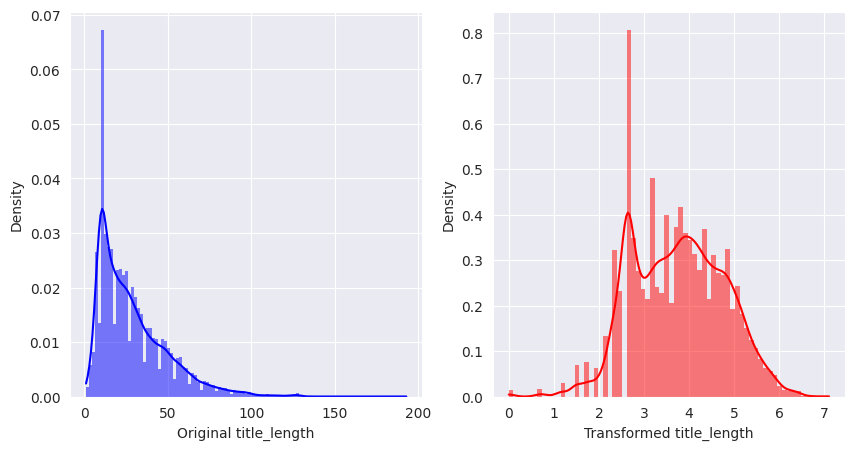


 ------------------------------------------------------

 'body_length' had 'positive' skewness of 7.87

 Transformation yielded skewness of 0.00


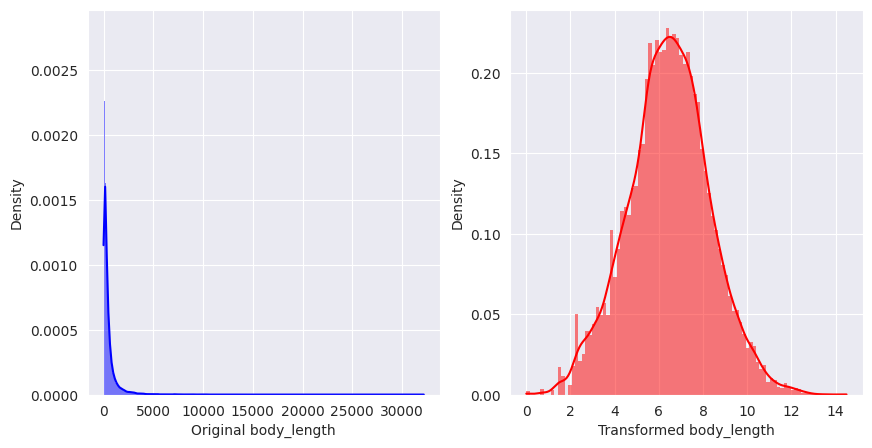


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'title_positivity' . Skewness = 0.44


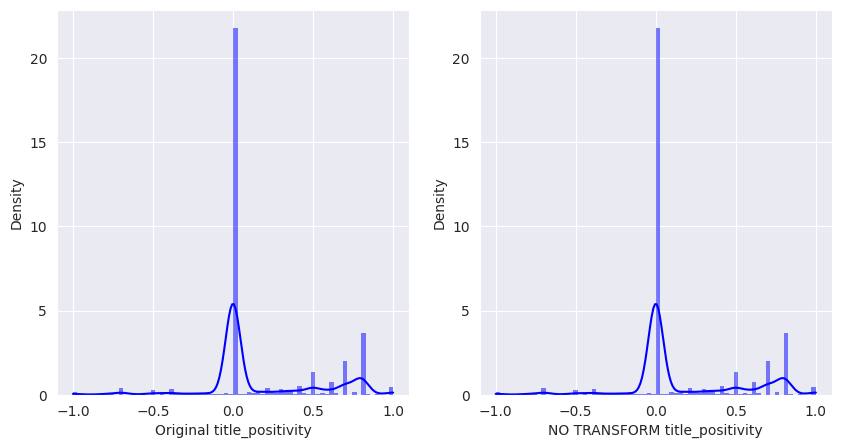


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'title_subjectivity' . Skewness = 0.78


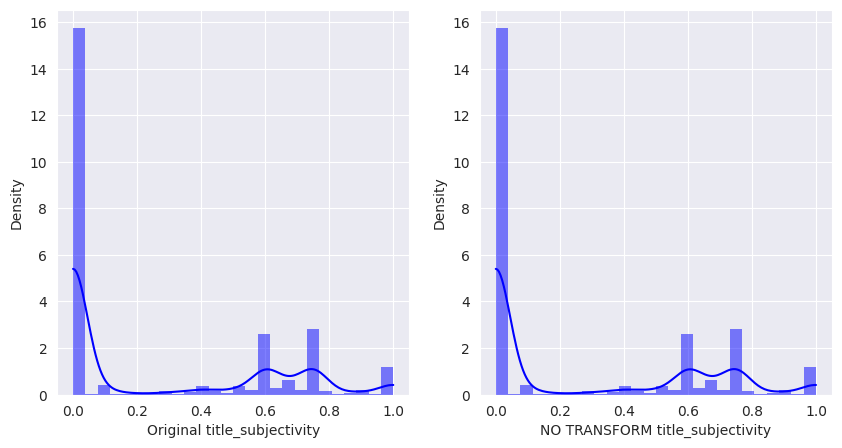


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'body_positivity' . Skewness = -0.04


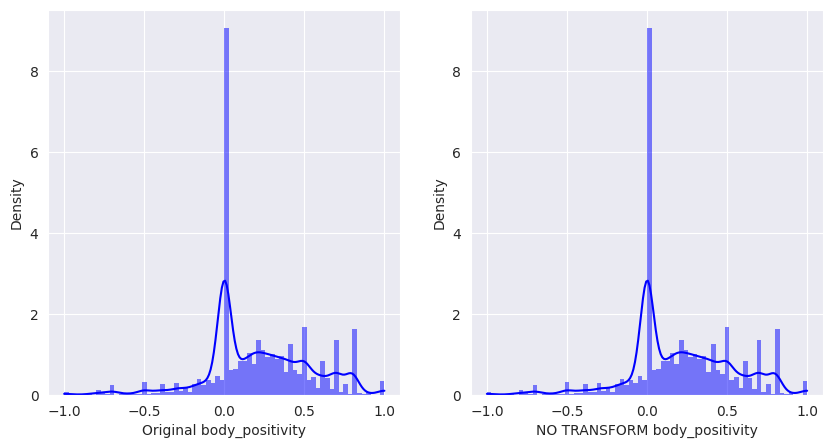


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'body_subjectivity' . Skewness = -0.38


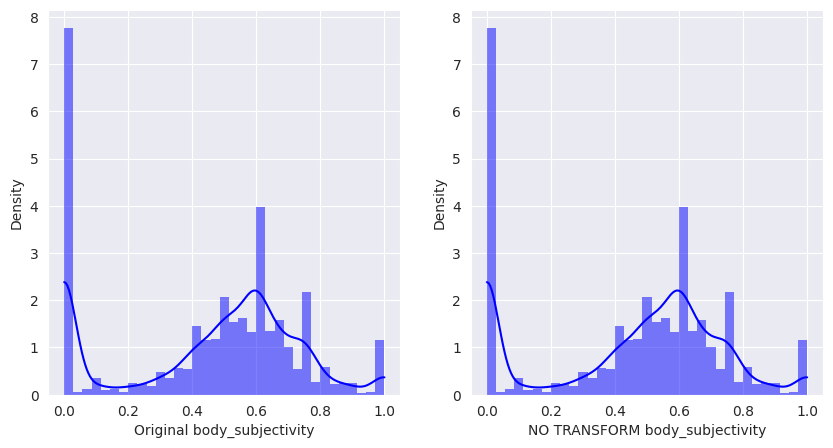

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
# All the predictors are real-valued, so we can push them all through the skewness check/correction.
X_quant = skew_autotransform(X_quant.copy(deep=True), plot = True, exp = False, threshold = 1)

In [ ]:
# Tukey Rule outliers
# As an alternative, you could use z-scores greater than 3 or less than -3.

cols = X_quant.columns
#Tukey's method
def tukey_rule(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_lim = data[col].quantile(0.5) + 2 * IQR
    lower_lim = data[col].quantile(0.5) - 2 * IQR
    outliers = []
    for index, x in enumerate(data[col]):
        if x < lower_lim or x >= upper_lim:
            outliers.append(index)
    return outliers

# Identify outliers
for i in cols:
  outliers_Tukey = tukey_rule(X_quant,i)
  print("Column ",i,": ",outliers_Tukey)

# Windsorize X and check the results
print("Descriptive Statistics Before", X_quant.describe())
X_quant_winsorized = X_quant.copy(deep=True)
for i in cols:
  X_quant_winsorized[i] = winsorize(X_quant[i], limits=(0.05, 0.05))
print("Descriptive Statistics After", X_quant_winsorized.describe())

Column  title_length :  [6004, 7205, 10139, 10857, 11502, 11626, 11739, 12697, 14337, 14821, 14899, 15325, 15591, 15786, 16733, 17032, 17232, 17244, 17599, 17901, 18299, 19107, 19433, 19670, 19676, 20041, 20209, 21207, 21208, 21385, 21787, 21874, 22156, 22386, 23142, 23735, 23898, 23971, 24781, 24796, 25160, 25242, 25532, 26762]
Column  body_length :  [35, 274, 539, 565, 598, 1082, 1095, 1100, 1255, 1370, 1371, 1382, 1441, 1443, 1464, 1488, 1528, 1543, 1571, 1607, 1619, 1647, 1652, 1661, 1676, 1679, 1696, 1729, 1823, 1917, 1936, 1949, 1954, 2050, 2073, 2221, 2287, 2310, 2342, 2369, 2371, 2372, 2384, 2418, 2419, 2480, 2506, 2511, 2745, 2794, 2902, 2903, 2904, 2962, 3027, 3044, 3073, 3206, 3244, 3477, 3528, 3583, 3617, 3645, 3671, 3697, 3830, 3943, 3948, 4005, 4136, 4280, 4484, 4633, 4640, 4706, 4707, 4741, 4780, 4845, 4859, 4916, 4970, 5021, 5164, 5169, 5360, 5361, 5362, 5364, 5370, 5373, 5485, 5535, 5618, 5622, 5624, 5626, 5627, 5630, 5631, 5632, 5634, 5636, 5693, 5726, 6007, 6139, 626

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [ ]:
# Concatenate quants and categoricals to obtain predictors
X = pd.concat([df['time'],X_quant_winsorized,X_categorical,],axis=1)

In [ ]:
# Review columns of dataframe
df.columns

Index(['rating', 'helpfulVotes', 'time', 'verified_True', 'title_length',
       'body_length', 'title_positivity', 'title_subjectivity',
       'body_positivity', 'body_subjectivity'],
      dtype='object')

#**Feature Importance**
We'll use the entire dataset to generate featire importance numbers.

In [ ]:
# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc1 = StandardScaler()
X_std = stdsc1.fit_transform(X)
y=pd.DataFrame(y)
stdsc2 = StandardScaler()
y_std = stdsc2.fit_transform(y)

<ipython-input-27-65aa571d95b5>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_std, y_std)                  # Fit the RandomForest instance using the traiing data


<BarContainer object of 9 artists>

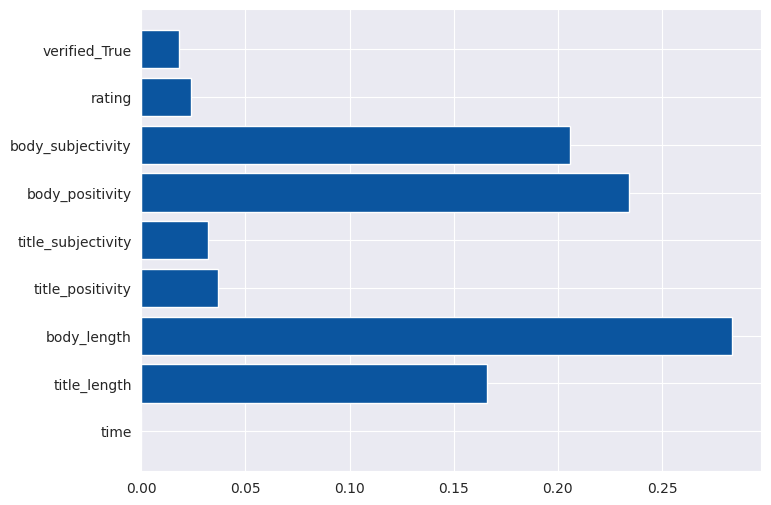

In [ ]:
# Feature Importance
# Code adapted from this source: https://machinelearningmastery.com/calculate-feature-importance-with-python/
# Let's try to weed out the really poor predictors
from matplotlib import pyplot                            # Import pyplot (to be able generate the barchart later in this snippet)
plt.rcParams["figure.figsize"] = (8,6)
model = RandomForestRegressor()                         # Create an instance of a RandomForestClassifier
# fit the model
model.fit(X_std, y_std)                  # Fit the RandomForest instance using the traiing data
# get importance
importance = model.feature_importances_                  # The RandomForestClassifier instance computes feature importance as a bonus. Store them imprtance values in importance'.
# summarize feature importance
plt.barh(col_names, model.feature_importances_)

#**Regressor Development**


In [ ]:
# Regressor Development and Assessment

names = ['Multiple Linear Regression', 'Lasso Regression', 'Ridge Regression','ElasticNet Regression','kNN', 'SVM','Decision Tree', 'Multilayer Perceptron','Random Forest', 'XGBoost', 'AdaBoost','LightGBM']
regressors = [linear_model.LinearRegression(),
              Lasso(alpha=0.5),
              Ridge(alpha=0.5),
              ElasticNet(alpha=0.25, l1_ratio=0.5),
              KNeighborsRegressor(n_neighbors=5),
              SVR(kernel = 'poly'),   #Can try kernels 'poly', 'linear', 'rbf' and 'sigmoid' kernels
              DecisionTreeRegressor(),
              MLPRegressor(hidden_layer_sizes=(25,25,1),
                       max_iter = 1000,activation = 'relu',
                       solver = 'adam'),
              RandomForestRegressor(criterion='squared_error'),
              XGBRegressor(objective ='reg:squarederror'),
              AdaBoostRegressor(loss='square'),
              lgb.LGBMRegressor(objective='mean_squared_error')
              ]

for name, regr in zip(names, regressors):
  print('REGRESSOR: ',name)
  pipe = Pipeline(steps=[('normalize', MinMaxScaler()), ('model', regr)])
  model = TransformedTargetRegressor(regressor=pipe, transformer=MinMaxScaler())
  cv = KFold(n_splits=10, shuffle=True, random_state=1)
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
  score_mean = mean(absolute(scores))
  score_stdev = np.std(scores)
  print('Mean (std Dev) of MSE: %.3f (%.3f)\n' % (score_mean, score_stdev))

REGRESSOR:  Multiple Linear Regression
Mean (std Dev) of MSE: 995.221 (194.925)

REGRESSOR:  Lasso Regression
Mean (std Dev) of MSE: 1020.981 (196.907)

REGRESSOR:  Ridge Regression
Mean (std Dev) of MSE: 995.221 (194.926)

REGRESSOR:  ElasticNet Regression
Mean (std Dev) of MSE: 1020.981 (196.907)

REGRESSOR:  kNN
Mean (std Dev) of MSE: 1132.369 (170.956)

REGRESSOR:  SVM
Mean (std Dev) of MSE: 9200.601 (449.323)

REGRESSOR:  Decision Tree
Mean (std Dev) of MSE: 1879.284 (194.369)

REGRESSOR:  Multilayer Perceptron
Mean (std Dev) of MSE: 1014.199 (194.959)

REGRESSOR:  Random Forest


KeyboardInterrupt: ignored

#**Gridsearch XGBoost Regressor**

In [ ]:
# Gridsearch the XGBoostRegressor hyperparameter space
model = XGBRegressor(objective ='reg:squarederror')
# define the grid of values to search
grid = dict()
grid['learning_rate']= [.05, 0.07]
grid['max_depth']= [7, 9]
grid['n_estimators'] = [400]
cv = RepeatedKFold(n_splits=4, n_repeats=2, random_state=192837465)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (absolute(mean), stdev, param))

#**Sample Actual vs Predicted Graph**

In [ ]:
# Create holdout sample
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.25,    # 75-25 training vs test set split
                     random_state=0)

X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

In [ ]:
# Standardization z-score
stdsc1 = StandardScaler()
X_train_std = stdsc1.fit_transform(X_train)
X_test_std = stdsc1.transform(X_test)
stdsc2 = StandardScaler()
y_train_std = stdsc2.fit_transform(y_train)
y_test_std = stdsc2.transform(y_test)

In [ ]:
# Report performance
def Performance(actuals,predictions):
  print('MSE: %.2f ' % mean_squared_error(actuals, predictions))
  print('MAPE: %.2f ' % mean_absolute_percentage_error(actuals,predictions))
  print('R^2: %.4f' % r2_score(actuals, predictions))

# Plotting the actuals vs predictions
def PredsVsActuals(actuals,predictions):
  plt.plot(actuals, predictions, '.', color='blue')
  plt.xlabel('Actuals')
  plt.ylabel('Predictions')
  plt.show()

MSE: 1011.23 
MAPE: 3.35 
R^2: 0.0401


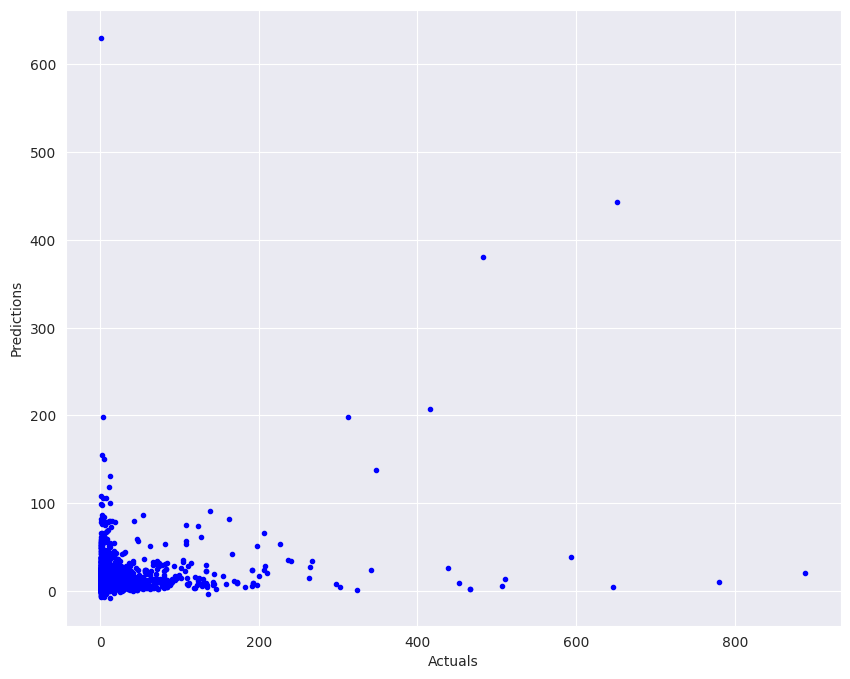

In [ ]:
#Fit XGBRegressor and produce graph and performance results for holdout sample
regr = XGBRegressor(objective ='reg:squarederror',learning_rate=0.05,max_depth=7,n_estimators=400)
regr.fit(X_train_std, np.ravel(y_train_std))
# Make predictions
y_pred_std = regr.predict(X_test_std)
y_pred_std = pd.DataFrame(y_pred_std)
y_pred = stdsc2.inverse_transform(y_pred_std)
# Performance
plt.figure(figsize=(10,8))
Performance(y_test,y_pred)
PredsVsActuals(y_test,y_pred)


#**Learning Curves (With Cross Validation)**

In [ ]:
# Libraries
from sklearn.svm import SVR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.model_selection import ShuffleSplit
from xgboost import XGBRegressor
!pip install lightgbm
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Specify training set size for all cross validation folds
train_size = 0.2 * len(X)



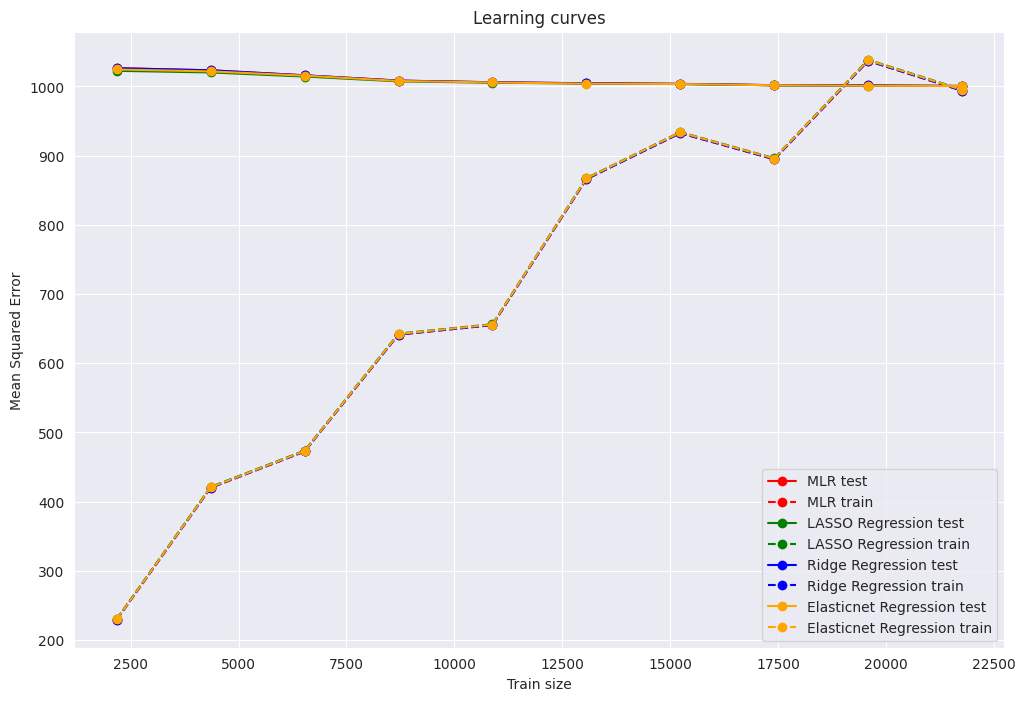

In [ ]:
# Learning Curves for multiple lnear regerssion, LASSO regression, ridge regression, and elasticnet regression
MLR = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', linear_model.LinearRegression()]])

lasso = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor',Lasso(alpha=0.5)]])

ridge = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', Ridge(alpha=0.5)]])

elasticnet = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', ElasticNet(alpha=0.25, l1_ratio=0.5)]])

train_sizes, train_scores_MLR, test_scores_MLR = learning_curve(
    MLR,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_lasso, test_scores_lasso = learning_curve(
    lasso,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_ridge, test_scores_ridge = learning_curve(
    ridge,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_elasticnet, test_scores_elasticnet = learning_curve(
    elasticnet,
    X,
    y,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)

# Figure size
plt.rcParams["figure.figsize"] = (12,8)
plt.figure()

plt.plot(train_sizes, -test_scores_MLR.mean(1), "o-", color="r", label="MLR test")
plt.plot(train_sizes, -train_scores_MLR.mean(1), "o--", color="r", label="MLR train")
plt.plot(train_sizes, -test_scores_lasso.mean(1), "o-", color="g", label="LASSO Regression test")
plt.plot(train_sizes, -train_scores_lasso.mean(1), "o--", color="g", label="LASSO Regression train")
plt.plot(train_sizes, -test_scores_ridge.mean(1), "o-", color="blue", label="Ridge Regression test")
plt.plot(train_sizes, -train_scores_ridge.mean(1), "o--", color="blue", label="Ridge Regression train")
plt.plot(train_sizes, -test_scores_elasticnet.mean(1), "o-", color="orange", label="Elasticnet Regression test")
plt.plot(train_sizes, -train_scores_elasticnet.mean(1), "o--", color="orange", label="Elasticnet Regression train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")
plt.show()






In [ ]:
#Learning Curves for SVR, DecisionTreeRegressor, KNN and MLP Regressors
# *************** EXTREMELY COMPUTATIONALLY INTENSIVE (~45 min on Colab Pro) ***********************
MLP = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', MLPRegressor(hidden_layer_sizes=(25,25,1), max_iter = 1000,activation = 'relu', solver = 'adam')]])

kNN = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', KNeighborsRegressor(n_neighbors=5)]])

dt = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', DecisionTreeRegressor()]])

svr = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', SVR()]])
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
train_sizes_abs, train_scores_dt, test_scores_dt = learning_curve(
    dt,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_kNN, test_scores_kNN = learning_curve(
    kNN,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_MLP, test_scores_MLP = learning_curve(
    MLP,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=3,
)
# Figure size
plt.rcParams["figure.figsize"] = (12,8)
plt.figure()
plt.plot(train_sizes, -test_scores_svr.mean(1), "o-", color="red", label="SVR test")
plt.plot(train_sizes, -train_scores_svr.mean(1), "o--", color="red", label="SVR train")
plt.plot(train_sizes, -test_scores_dt.mean(1), "o-", color="green", label="DT test")
plt.plot(train_sizes, -train_scores_dt.mean(1), "o--", color="green", label="DT train")
plt.plot(train_sizes, -test_scores_kNN.mean(1), "o-", color="blue", label="KNN test")
plt.plot(train_sizes, -train_scores_kNN.mean(1), "o--", color="blue", label="KNN train")
plt.plot(train_sizes, -test_scores_MLP.mean(1), "o-", color="orange", label="Multilayer Perceptron test")
plt.plot(train_sizes, -train_scores_MLP.mean(1), "o--", color="orange", label="Multilayer Perceptron train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

In [ ]:
# Learning curves for Random Forest, XGBoost, LightGBM and Adaboost Regressors
# *************** COMPUTATIONALLY INTENSIVE (~35min on Colab Pro) ***********************
XGB = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', XGBRegressor(objective ='reg:squarederror')]])

RF = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', RandomForestRegressor(criterion='squared_error')]])

LGBM = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor', LGBMRegressor(objective='mean_squared_error')]])

adaboost = imbpipeline(steps = [['scaler', StandardScaler()],
                                ['regressor',AdaBoostRegressor(loss='square')]])
train_sizes, train_scores_RF, test_scores_RF = learning_curve(
    RF,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_XGB, test_scores_XGB = learning_curve(
    XGB,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_LGBM, test_scores_LGBM = learning_curve(
    LGBM,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
train_sizes_abs, train_scores_adaboost, test_scores_adaboost = learning_curve(
    adaboost,
    X,
    np.ravel(y),
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_squared_error",
    cv=5,
)
# Figure size
plt.rcParams["figure.figsize"] = (12,8)
plt.figure()
plt.plot(train_sizes, -test_scores_RF.mean(1), "o-", color="red", label="RF test")
plt.plot(train_sizes, -train_scores_RF.mean(1), "o--", color="red", label="RF train")
plt.plot(train_sizes, -test_scores_LGBM.mean(1), "o-", color="green", label="LGBM test")
plt.plot(train_sizes, -train_scores_LGBM.mean(1), "o--", color="green", label="LGBM train")
plt.plot(train_sizes, -test_scores_XGB.mean(1), "o-", color="blue", label="XGB test")
plt.plot(train_sizes, -train_scores_XGB.mean(1), "o--", color="blue", label="XGB train")
plt.plot(train_sizes, -test_scores_adaboost.mean(1), "o-", color="orange", label="Adaboost test")
plt.plot(train_sizes, -train_scores_adaboost.mean(1), "o--", color="orange", label="Adaboost train")
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

#**Over Predictions (Predictions > Actuals)**

In [ ]:
# Percentage overprediction
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
results = pd.concat([y_pred, y_test.set_index(y_pred.index)], axis=1)
results.columns=['Pred','Act']
results['%error'] = 100* (results.Pred - results.Act)/results.Act
results = pd.DataFrame(results)
ovr_pred = 0
for index, instance in results.iterrows():
    if results.at[index,'%error'] > 0:
        ovr_pred = ovr_pred + 1
print('Percentage of instance overpredicted: ',100*ovr_pred/len(results))

In [ ]:
# Examine actuals, predictions & errors
results.head(10)

#**Conclusions**

* A regressor horse race was staged, which was likely won by the RandomForestRegeressor, with an MSE of around 900. This indictes that we are working with a tough dataset.
* The XGBRegressor was tuned, yielding an average MSE of 960.
* The learning curves suggest that all the regression models, SVR, Multilayer Perceptron, LightGBM and XGBoost regressors are well fitted.
* Given the relatively low stakes, and the ability to cut over to actual helpful votes once enough of them have accumulated, automated use of regressor can proceed, but the modeling should be revisited to see if improvements are possible.
